In [1]:
import torch 
import numpy as np
import pandas as pd 
from utilities import *
from math import ceil
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn as nn
from torch.autograd import Variable

In [2]:
finances = financial_dataset('NVDA', num_of_labels=2)
finances

[*********************100%***********************]  1 of 1 completed
NVDA financial dataframe dimensions  (2770, 6)
Positive changes : 1454
Negative changes : 1316
No changes : 0


,Open,Close,Volume,Price_change,date
Date,,,,,
2009-12-31,4.677500,4.670000,70034000,1,0
2010-01-04,4.627500,4.622500,80020400,-1,2010-01-04
2010-01-05,4.605000,4.690000,72864800,1,2010-01-05
2010-01-06,4.687500,4.720000,64916800,1,2010-01-06
2010-01-07,4.695000,4.627500,54779200,-1,2010-01-07
...,...,...,...,...,...
2020-12-24,130.372498,129.937500,9788400,-1,2020-12-24
2020-12-28,130.625000,129.000000,21256400,-1,2020-12-28
2020-12-29,129.250000,129.432495,17037200,1,2020-12-29


### Create dataset 

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [10]:
stocks = ['NVDA']
big_df = pd.DataFrame()
# Read finances and news for all stocks in list and create a big dataframe.
for stock in stocks :
    news = read_news(stock)
    finances = financial_dataset(stock, num_of_labels=2)
    merged_df = merge_fin_news(finances, news, how='inner')
    print(f"Performing sentiment analysis for stock {stock}")
    sentimentized_df = sentim_analyzer(merged_df, tokenizer, model)
    # average sentiment for each unique date.
    sentimentized_df = merge_dates(sentimentized_df)
    big_df = pd.concat([big_df, sentimentized_df], axis=0, ignore_index=True)

The bot found 3133 headlines from analyst_ratings_processed.csv, regarding NVDA stock
The bot found 0 headlines from raw_partner_headlines.csv, regarding NVDA stock
The bot found 3133 headlines in total, regarding NVDA stock
[*********************100%***********************]  1 of 1 completed
NVDA financial dataframe dimensions  (2770, 6)
Positive changes : 1454
Negative changes : 1316
No changes : 0
Performing sentiment analysis for stock NVDA


100%|██████████████████████████████████████████████████████████████████████████████| 3057/3057 [04:19<00:00, 11.77it/s]


 Dataframe now contains sentiment score for 1122 different dates.


### Or load it if it's already on system

In [11]:
big_df.to_csv('Datasets/nvdia_mix.csv')
big_df

,date,stock,Open,Close,Volume,Positive,Negative,Neutral,Price_change
0,2011-03-03,NVDA,5.307500,5.217500,159370400,0.015090,0.825096,0.159814,1
1,2011-03-07,NVDA,5.227500,5.117500,101914000,0.064805,0.025756,0.909439,-1
2,2011-03-08,NVDA,5.172500,4.887500,194718400,0.331308,0.294181,0.374511,-1
3,2011-03-09,NVDA,4.872500,4.785000,131897600,0.060045,0.017414,0.922541,-1
4,2011-03-10,NVDA,4.675000,4.480000,172273600,0.070367,0.041462,0.888172,-1
...,...,...,...,...,...,...,...,...,...
1117,2020-05-28,NVDA,84.122498,84.870003,73489600,0.547186,0.007260,0.445554,-1
1118,2020-06-02,NVDA,87.962502,88.252502,39132000,0.080008,0.309448,0.610544,1
1119,2020-06-08,NVDA,88.772499,88.050003,38773600,0.040860,0.346767,0.612373,-1
1120,2020-06-09,NVDA,88.000000,90.459999,46848800,0.957068,0.022495,0.020436,1


In [289]:
big_df = pd.read_csv('Datasets/nvdia_mix.csv')

### Pre-process dataset
Create a time series dataset, features consist of the previous day's close price while today's close price is the label.

In [290]:
seq_len = 1
# start creating sequences only after the first seq_len elements have passed 
X = np.zeros((big_df.shape[0] - seq_len, 4))
y = np.zeros((big_df.shape[0] - seq_len, 1))
print("X shape :",X.shape)
print("y shape :",y.shape)

X shape : (1121, 4)
y shape : (1121, 1)


In [291]:
for i in range(seq_len , X.shape[0] + seq_len) :
    prev_elems = big_df.iloc[i-seq_len][['Close', 'Positive', 'Negative', 'Neutral']] # previous available date
    # only the desired values
    prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]
    prev_elems = np.array(prev_elems)
    # Store previous day close price as feature 
    X[i-seq_len] = prev_elems
    # Store "today's" close price as label
    y[i-seq_len] = big_df.iloc[i]['Close']

### Normalise dataset and split into train-test.
Min - Max scaling 

In [292]:
# transform features with standard scaler, and output values (close prices) to [0,1] with minmax scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
#ss = StandardScaler()

X_mm = mm.fit_transform(X)
y_mm = mm.fit_transform(np.array(y).reshape(-1, 1))

Data splitting into train,val, test . 

In [293]:
# fraction of the test set.
percentage = 0.3
split_tr = ceil(X_mm.shape[0] *(1-percentage))
split_val = ceil(X_mm.shape[0] *(1- percentage/2))

X_train = X_mm[0:split_tr]
y_train = y_mm[0:split_tr]
X_val= X_mm[split_tr: split_val]
y_val= y_mm[split_tr: split_val]
X_test= X_mm[split_val:]
y_test= y_mm[split_val:]
print(f"Train data shapes X:{X_train.shape} , y:{y_train.shape}")
print(f"Test data shapes X:{X_test.shape} , y:{y_test.shape}")
print(f"Val data shapes X:{X_val.shape} , y:{y_val.shape}")

Train data shapes X:(785, 4) , y:(785, 1)
Test data shapes X:(168, 4) , y:(168, 1)
Val data shapes X:(168, 4) , y:(168, 1)


### Convert np.arrays into tensors and reshape in the format expected by the LSTM .

In [294]:
X_tensors = Variable(torch.Tensor(X_mm))
y_tensors = Variable(torch.Tensor(y_mm))
#reshaping to rows, timestamps, features
X_tensors = torch.reshape(X_tensors,   (X_tensors.shape[0], 1, X_tensors.shape[1]))
y_tensors = torch.reshape(y_tensors,  (y_tensors.shape[0], 1, y_tensors.shape[1]))


In [295]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
X_val_tensors = Variable(torch.Tensor(X_val))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))
y_val_tensors = Variable(torch.Tensor(y_val))

In [296]:
#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
X_val_tensors_final = torch.reshape(X_val_tensors,  (X_val_tensors.shape[0], 1, X_val_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)
print("Testing Shape", X_val_tensors_final.shape, y_val_tensors.shape)

Training Shape torch.Size([785, 1, 4]) torch.Size([785, 1])
Testing Shape torch.Size([168, 1, 4]) torch.Size([168, 1])
Testing Shape torch.Size([168, 1, 4]) torch.Size([168, 1])


### Define LSTM structure .
The LSTM will execute regression, so MSE loss is need during training. 

In [297]:
class LSTM_reg(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout=0.3, fc_size = 128):
        super(LSTM_reg, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout) #lstm
        
        self.fc_1 =  nn.Linear(hidden_size * num_layers, fc_size) #fully connected 1
        self.fc = nn.Linear(fc_size, num_classes) #fully connected last layer

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state 1st lstm layer
        c_0_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state 1st lstm layer

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0_0, c_0_0)) #lstm with input, hidden, and internal state
       # print(output.shape)
       # print(hn.shape)
        hn = hn.view(-1, self.hidden_size * num_layers) #reshaping (flatten) the data for Dense layer next
       # print(hn.shape)
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output

        return out

In [298]:
#hyperparameters
num_epochs = 1000 #1000 epochs
learning_rate = 0.0003 #0.001 lr

input_size = 4 #number of features
hidden_size = 60 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

lstm_reg = LSTM_reg(num_classes, input_size, hidden_size, num_layers, dropout=0.3, fc_size=128) #our lstm class

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm_reg.parameters(), lr=learning_rate)

C:\Users\Konpoul\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


#### Training loop

In [299]:
plot_loss_tr = []
plot_loss_val = []
for epoch in tqdm(range(num_epochs)):
    outputs = lstm_reg.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
    plot_loss_tr.append(loss.item())
    loss.backward() #calculates the loss of the loss function

    # Compute validation loss
    val_outs = lstm_reg.forward(X_val_tensors_final) #forward pass
    val_loss = criterion(val_outs, y_val_tensors)
    plot_loss_val.append(val_loss.item())

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, train_loss: %1.5f,  val_loss: %1.5f " % (epoch, loss.item(), val_loss.item()))

  2%|█▎                                                                              | 17/1000 [00:00<00:11, 86.87it/s]

Epoch: 0, train_loss: 0.12509,  val_loss: 0.30611 


 12%|█████████▍                                                                    | 121/1000 [00:01<00:07, 113.09it/s]

Epoch: 100, train_loss: 0.04777,  val_loss: 0.07936 


 22%|████████████████▊                                                             | 215/1000 [00:02<00:07, 107.00it/s]

Epoch: 200, train_loss: 0.02905,  val_loss: 0.04644 


 32%|████████████████████████▋                                                     | 317/1000 [00:03<00:06, 107.31it/s]

Epoch: 300, train_loss: 0.00184,  val_loss: 0.00326 


 42%|████████████████████████████████▉                                             | 422/1000 [00:03<00:04, 117.32it/s]

Epoch: 400, train_loss: 0.00009,  val_loss: 0.00055 


 52%|████████████████████████████████████████▏                                     | 516/1000 [00:04<00:04, 102.94it/s]

Epoch: 500, train_loss: 0.00009,  val_loss: 0.00055 


 61%|███████████████████████████████████████████████▋                              | 612/1000 [00:05<00:03, 110.61it/s]

Epoch: 600, train_loss: 0.00009,  val_loss: 0.00056 


 71%|███████████████████████████████████████████████████████▎                      | 709/1000 [00:06<00:02, 103.06it/s]

Epoch: 700, train_loss: 0.00009,  val_loss: 0.00056 


 81%|███████████████████████████████████████████████████████████████▍              | 813/1000 [00:07<00:01, 112.91it/s]

Epoch: 800, train_loss: 0.00009,  val_loss: 0.00056 


 92%|███████████████████████████████████████████████████████████████████████▉      | 922/1000 [00:08<00:00, 108.52it/s]

Epoch: 900, train_loss: 0.00009,  val_loss: 0.00056 


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.53it/s]


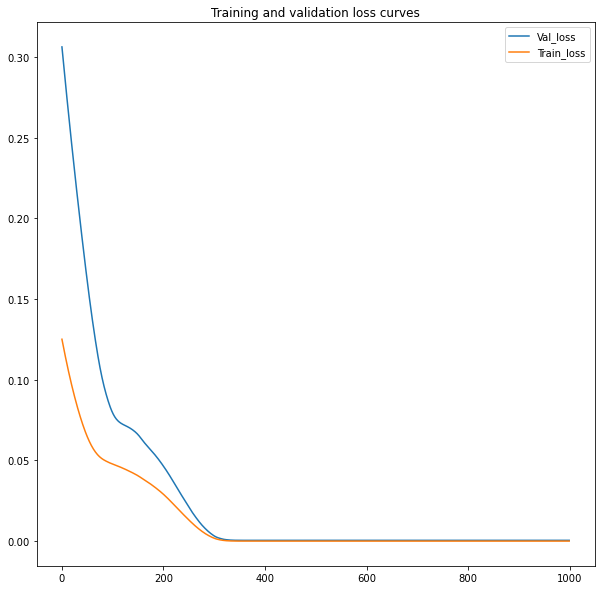

In [300]:
fig , ax = plt.subplots(figsize = (10,10))

plt.plot(plot_loss_val, label='Val_loss') #actual plot
plt.plot(plot_loss_tr, label='Train_loss') #predicted plot
plt.title('Training and validation loss curves')
plt.legend()
plt.show()

### Predicting with the LSTM

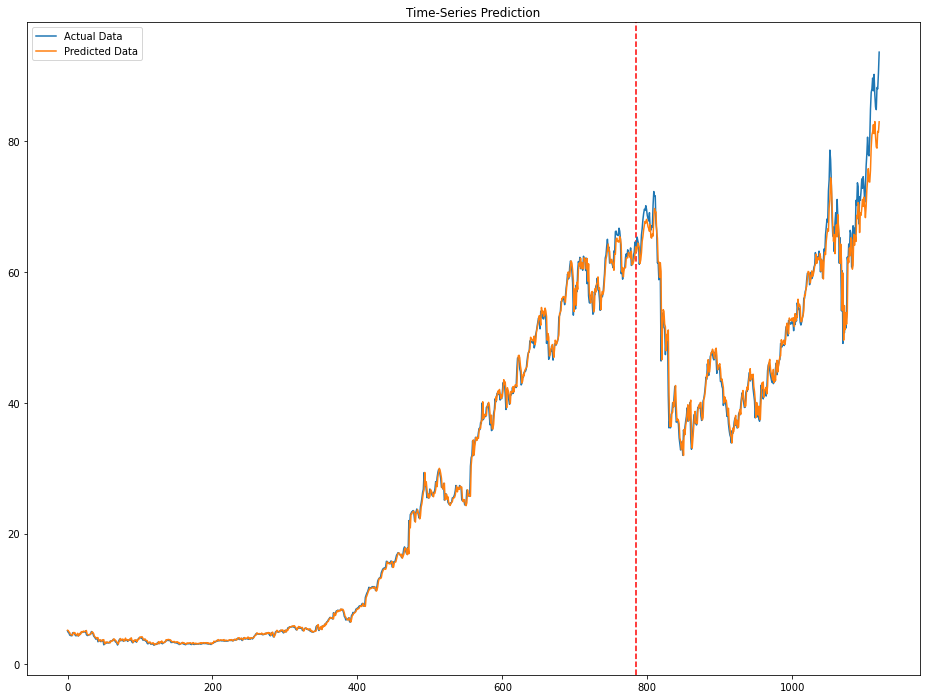

In [301]:
train_predict = lstm_reg(X_tensors) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_tensors.data.numpy()
dataY_plot =  np.reshape(dataY_plot, (dataY_plot.shape[0],1))

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(16,12)) #plotting
plt.axvline(x=split_tr, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

### Evaluation of regression predictions with MSE and Spearman Correlation. 

In [302]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[split_tr : split_val] - data_predict[split_tr : split_val], 2).mean())
print("VAL DATA, MSE loss : ", mse)

VAL DATA, MSE loss :  4.579165


In [303]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[:split_tr] - data_predict[:split_tr], 2).mean())
print("TRAIN DATA , MSE loss : ", mse)

TRAIN DATA , MSE loss :  0.73128843


In [304]:
from scipy.stats import spearmanr
#from sklearn.metric import mean_squared_error
spearman = spearmanr(dataY_plot[split_tr : split_val], data_predict[split_tr : split_val])
print("Val DATA,  Spreaman correlation : ", spearman)

#from sklearn.metric import mean_squared_error
spearman = spearmanr(dataY_plot[:split_tr],data_predict[:split_tr])
print("TRAIN DATA , Spreaman correlation : ", spearman)

Val DATA,  Spreaman correlation :  SpearmanrResult(correlation=0.9584761162375166, pvalue=2.2770395322231275e-92)
TRAIN DATA , Spreaman correlation :  SpearmanrResult(correlation=0.9960944689171674, pvalue=0.0)


#### Test dataset evaluation (Run only once at the end)

In [305]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[split_val:] - data_predict[split_val:], 2).mean())
print("TEST DATA, MSE loss : ", mse)

spearman = spearmanr(dataY_plot[split_val:],data_predict[split_val:])
print("TEST DATA,  Spreaman correlation : ", spearman)

TEST DATA, MSE loss :  11.7850685
TEST DATA,  Spreaman correlation :  SpearmanrResult(correlation=0.9745774401046471, pvalue=9.116653316249002e-110)


# 2.) Classification of price movement with LSTM 

## Pre-process dataset


### Price_change is the class . 0: decrease , +1 : increase

Normalise the Close price column and convert Price_change column to (0,1) instead of (-1, 1). 

In [190]:
big_df['Price_change'] = big_df['Price_change'].apply(lambda x : x+1 if (x==-1) else x)
big_df['Close'] = (big_df['Close']-big_df['Close'].min())/(big_df['Close'].max()-big_df['Close'].min())
big_df

,date,stock,Open,Close,Volume,Positive,Negative,Neutral,Price_change
0,2011-03-03,NVDA,5.307500,0.025183,159370400,0.015090,0.825096,0.159814,1
1,2011-03-07,NVDA,5.227500,0.024081,101914000,0.064805,0.025756,0.909439,0
2,2011-03-08,NVDA,5.172500,0.021546,194718400,0.331308,0.294181,0.374511,0
3,2011-03-09,NVDA,4.872500,0.020417,131897600,0.060045,0.017414,0.922541,0
4,2011-03-10,NVDA,4.675000,0.017055,172273600,0.070367,0.041462,0.888172,0
...,...,...,...,...,...,...,...,...,...
1117,2020-05-28,NVDA,84.122498,0.903042,73489600,0.547186,0.007260,0.445554,0
1118,2020-06-02,NVDA,87.962502,0.940321,39132000,0.080008,0.309448,0.610544,1
1119,2020-06-08,NVDA,88.772499,0.938089,38773600,0.040860,0.346767,0.612373,0
1120,2020-06-09,NVDA,88.000000,0.964650,46848800,0.957068,0.022495,0.020436,1


In [193]:
seq_len = 1
# start creating sequences only after the first seq_len elements have passed 
X = np.zeros((big_df.shape[0] - seq_len, 4))
y = np.zeros((big_df.shape[0] - seq_len, 2))
print("X shape :",X.shape)
print("y shape :",y.shape)

X shape : (1121, 4)
y shape : (1121, 2)


#### Sparse vector format labels.

In [195]:
for i in range(seq_len , X.shape[0] + seq_len) :
    prev_elems = big_df.iloc[i-seq_len][['Close', 'Positive', 'Negative', 'Neutral']] # previous available date
    # only the desired values
    prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]
    prev_elems = np.array(prev_elems)
    # Store previous 30 days close price
    X[i-seq_len] = prev_elems
   # y[i-seq_len]  = big_df.iloc[i]['Price_change']
    # Store label, close price of day 31 
    change = big_df.iloc[i]['Price_change']
    if change==0 : # decrease
        y[i-seq_len] = np.array([0, 1]) # vector for decrease
    else : 
        y[i-seq_len] = np.array([1, 0]) # vector for increase

#### Binary format labels

In [196]:
'''
for i in range(seq_len , X.shape[0] + seq_len) :
    prev_elems = big_df.iloc[i-seq_len][['Close', 'Positive', 'Negative', 'Neutral']] # previous available date
    # only the desired values
    prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]
    prev_elems = np.array(prev_elems)
    # Store previous 30 days close price
    X[i-seq_len] = prev_elems
    y[i-seq_len]  = big_df.iloc[i]['Price_change']
'''

"\nfor i in range(seq_len , X.shape[0] + seq_len) :\n    prev_elems = big_df.iloc[i-seq_len][['Close', 'Positive', 'Negative', 'Neutral']] # previous available date\n    # only the desired values\n    prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]\n    prev_elems = np.array(prev_elems)\n    # Store previous 30 days close price\n    X[i-seq_len] = prev_elems\n    y[i-seq_len]  = big_df.iloc[i]['Price_change']\n"

### Normalise dataset and split into train-test.
#### Convert np.arrays into tensors and reshape in the format expected by the LSTM .
Min - Max scaling 

In [197]:
# transform features with standard scaler, and output values (close prices) to [0,1] with minmax scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
#ss = StandardScaler()
#X_price_norm = mm.fit_transform(X[:,0])
X_mm = X # mm.fit_transform(X)

# fraction of the test set.
percentage = 0.4
split_tr = ceil(X_mm.shape[0] *(1-percentage))
split_val = ceil(X_mm.shape[0] *(1- percentage/2))

X_train = X_mm[0:split_tr]
y_train = y[0:split_tr]
X_val= X_mm[split_tr: split_val]
y_val= y[split_tr: split_val]
X_test= X_mm[split_val:]
y_test= y[split_val:]
print(f"Train data shapes X:{X_train.shape} , y:{y_train.shape}")
print(f"Test data shapes X:{X_test.shape} , y:{y_test.shape}")
print(f"Val data shapes X:{X_val.shape} , y:{y_val.shape}")

### TO tensors 
###
X_tensors = Variable(torch.Tensor(X_mm))
y_tensors = Variable(torch.Tensor(y))
#reshaping to rows, timestamps, features
X_tensors = torch.reshape(X_tensors,   (X_tensors.shape[0], 1, X_tensors.shape[1]))
y_tensors = torch.reshape(y_tensors,  (y_tensors.shape[0], 1, y_tensors.shape[1]))

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
X_val_tensors = Variable(torch.Tensor(X_val))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))
y_val_tensors = Variable(torch.Tensor(y_val))

#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
X_val_tensors_final = torch.reshape(X_val_tensors,  (X_val_tensors.shape[0], 1, X_val_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)
print("Validation Shape", X_val_tensors_final.shape, y_val_tensors.shape)

Train data shapes X:(673, 4) , y:(673, 2)
Test data shapes X:(224, 4) , y:(224, 2)
Val data shapes X:(224, 4) , y:(224, 2)
Training Shape torch.Size([673, 1, 4]) torch.Size([673, 2])
Testing Shape torch.Size([224, 1, 4]) torch.Size([224, 2])
Validation Shape torch.Size([224, 1, 4]) torch.Size([224, 2])


### Define classification LSTM  : We need to add a sigmoid activation function at the end in order to get output in the $[0,1]$ range.

In [269]:
class LSTM_clf(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout=0.3, fc_size = 128):
        super(LSTM_clf, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout) #lstm
        
        self.fc_1 =  nn.Linear(hidden_size * num_layers, fc_size) #fully connected 1
        self.fc = nn.Linear(fc_size, num_classes) #fully connected last layer
        self.dropout = nn.Dropout(p=dropout)

        self.relu = nn.ReLU()
        # sigmoid activation for end classification
        self.sigm = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self,x):
        h_0_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state 1st lstm layer
        c_0_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state 1st lstm layer

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0_0, c_0_0)) #lstm with input, hidden, and internal state
       # print(output.shape)
       # print(hn.shape)
        hn = hn.view(-1, self.hidden_size * num_layers) #reshaping (flatten) the data for Dense layer next
       # print(hn.shape)
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.dropout(out)
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        
        out = self.sigm(out)
        return out

#### Training the LSTM . 

In [277]:
#hyperparameters
num_epochs = 1000 #1000 epochs
learning_rate = 0.0001
input_size = 4 #number of features
hidden_size = 60 #number of features in hidden state
num_layers = 2 #number of stacked lstm layers

num_classes = 2 #number of output classes

lstm_clf = LSTM_clf(num_classes, input_size, hidden_size, num_layers, dropout = 0.3, fc_size=128)#X_train_tensors_final.shape[1]) #our lstm class

criterion = torch.nn.BCELoss() #   # mean-squared error for regression
optimizer = torch.optim.Adam(lstm_clf.parameters(), lr=learning_rate)


plot_loss_tr = []
plot_loss_val = []
for epoch in tqdm(range(num_epochs)):
    
    #print(X_train_tensors_final.shape)
    outputs = lstm_clf.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    #print(outputs.shape)
    #print(y_train_tensors.shape)
    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
    plot_loss_tr.append(loss.item())
    loss.backward() #calculates the loss of the loss function

    # Compute validation loss
    val_outs = lstm_clf.forward(X_val_tensors_final) #forward pass
    val_loss = criterion(val_outs, y_val_tensors)
    plot_loss_val.append(val_loss.item())
    
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, train_loss: %1.5f,  val_loss: %1.5f " % (epoch, loss.item(), val_loss.item()))

  0%|▍                                                                                | 5/1000 [00:00<00:21, 46.44it/s]

Epoch: 0, train_loss: 0.69302,  val_loss: 0.69247 


 11%|████████▋                                                                      | 110/1000 [00:01<00:15, 58.50it/s]

Epoch: 100, train_loss: 0.69109,  val_loss: 0.69091 


 21%|████████████████▌                                                              | 210/1000 [00:03<00:12, 63.45it/s]

Epoch: 200, train_loss: 0.68837,  val_loss: 0.69219 


 31%|████████████████████████▎                                                      | 308/1000 [00:05<00:11, 60.17it/s]

Epoch: 300, train_loss: 0.68787,  val_loss: 0.69441 


 41%|████████████████████████████████▍                                              | 410/1000 [00:06<00:09, 59.37it/s]

Epoch: 400, train_loss: 0.68726,  val_loss: 0.69751 


 51%|███████████████████████████████████████▉                                       | 506/1000 [00:08<00:09, 51.07it/s]

Epoch: 500, train_loss: 0.68707,  val_loss: 0.69531 


 61%|████████████████████████████████████████████████▎                              | 612/1000 [00:10<00:05, 65.38it/s]

Epoch: 600, train_loss: 0.68636,  val_loss: 0.69407 


 71%|████████████████████████████████████████████████████████                       | 710/1000 [00:11<00:04, 60.90it/s]

Epoch: 700, train_loss: 0.68514,  val_loss: 0.69428 


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [00:13<00:02, 64.49it/s]

Epoch: 800, train_loss: 0.68379,  val_loss: 0.69405 


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [00:15<00:01, 61.80it/s]

Epoch: 900, train_loss: 0.68287,  val_loss: 0.69320 


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.35it/s]


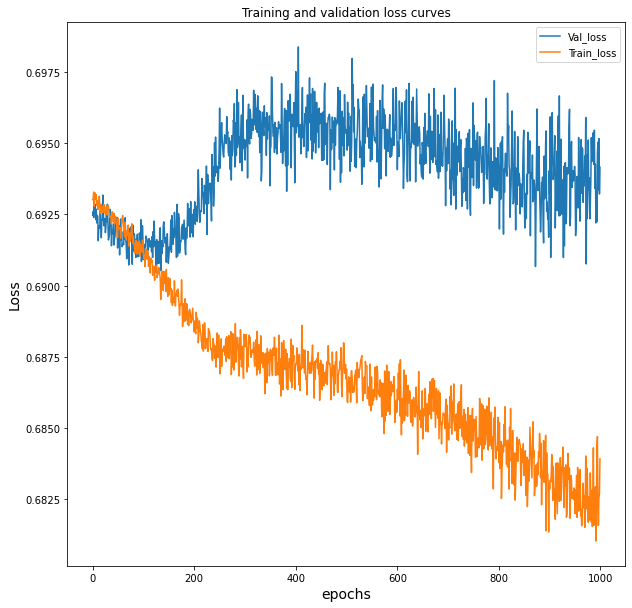

In [278]:
fig , ax = plt.subplots(figsize = (10,10))

plt.plot(plot_loss_val, label='Val_loss') #actual plot
plt.plot(plot_loss_tr, label='Train_loss') #predicted plot
plt.title('Training and validation loss curves')
plt.xlabel('epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.show()

### Prediction and evaluation of LSTM classifier .

 predictions in the right form to be accepted by sklearn accuracy functions and confusion matrix

In [284]:
train_predict = lstm_clf(X_tensors) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
for i in range(len(data_predict)):
    index = np.argmax(data_predict, axis=1) # np.where(data_predict >=0.5, 1, 0) #
    if (index[i] == 0) :
        data_predict[i][index] = 1
        data_predict[i][1] = 0 
    else :
        data_predict[i][0] = 0
        data_predict[i][1] = 1 

In [285]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

#from sklearn.metric import mean_squared_error
acc = accuracy_score(y[:split_tr], data_predict[:split_tr])
print("TRAIN DATA , accuracy : ", round(acc,6))

#bacc =  balanced_accuracy_score(y[:split_tr], predictions[:split_tr])
#print("TRAIN DATA , balanced accuracy : ", round(bacc,6))

acc = accuracy_score(y[split_tr : split_val], data_predict[split_tr : split_val])
print("VAL DATA, accuracy : ", round(acc,6))

TRAIN DATA , accuracy :  0.524517
VAL DATA, accuracy :  0.544643


In [286]:
# Number of increase predictions 
print("Number of increase label predictions :",data_predict[data_predict[:,0] == 1].shape)
print("Number of decrease label predictions :",data_predict[data_predict[:,1] == 1].shape)
print("Overall data dataset shape : ",data_predict.shape)

Number of increase label predictions : (714, 2)
Number of decrease label predictions : (407, 2)
Overall data dataset shape :  (1121, 2)


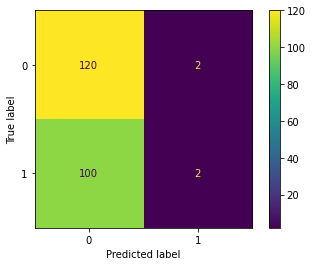

In [287]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_conf = np.argmax(y, axis=1)
pred_conf = np.argmax(data_predict, axis=1)

cm = confusion_matrix(y_conf[split_tr : split_val] , pred_conf[split_tr : split_val], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

#### TEST EVALUATION

TEST DATA, accuracy :  0.566964


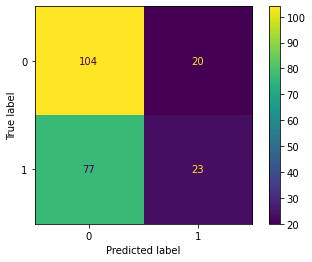

In [288]:
acc = accuracy_score(y_conf[split_val:], pred_conf[split_val:])
print("TEST DATA, accuracy : ", round(acc,6))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_conf[split_val:] , pred_conf[split_val:], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                         display_labels=[0,1])
disp.plot()
plt.show()